In [ ]:
# SET CONFIGURATION ARGUMENTS

args = {
    "nt": 1,
    "nb_epoch": 250,
    "batch_size": 1,
    "output_channels": [3, 48, 96, 192],
    "num_P_CNN": 1,
    "num_R_CLSTM": 1,
    "num_passes": 1,
    "pan_hierarchical": False,
    "downscale_factor": 4,
    "resize_images": False,
    "train_proportion": 0.7,
    "results_subdir": "dummy",
    "dataset_weights": "various",
    "data_subset_weights": "gen_ellipseV_crossH",
    "dataset": "general_shape_static",
    "data_subset": "general_ellipse_static_2nd_stage",
    "data_subset_mode": "test",
    "model_choice": "baseline",
    "system": "laptop",
    "reserialize_dataset": False,
    "output_mode": "Error"
}
args["results_subdir"] = f"interp_results/{args['dataset']}/{args['data_subset']}"

In [ ]:
# LOAD MODEL

import argparse
from config import update_settings, get_settings
from data_utils import serialize_dataset
import numpy as np
import os
from datetime import datetime


update_settings(args["system"], args["dataset_weights"], args["data_subset_weights"], args["results_subdir"])
DATA_DIR, WEIGHTS_DIR, RESULTS_SAVE_DIR, LOG_DIR = get_settings()["dirs"]
data_dirs = [DATA_DIR, WEIGHTS_DIR, RESULTS_SAVE_DIR, LOG_DIR]
if not os.path.exists(RESULTS_SAVE_DIR):
    os.makedirs(RESULTS_SAVE_DIR)

import os
import warnings
import hickle as hkl

# Suppress warnings
warnings.filterwarnings("ignore")
# or '2' to filter out INFO messages too
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import shutil
import keras
from keras import backend as K
from keras import layers
from data_utils import SequenceGenerator, IntermediateEvaluations, create_dataset_from_serialized_generator, config_gpus 
%matplotlib tk
import matplotlib.pyplot as plt
# import addcopyfighandler
from matplotlib.colors import LinearSegmentedColormap
import random

# PICK MODEL
if args["model_choice"] == "baseline":
    # Predict next frame along RGB channels only
    if not args['pan_hierarchical']:
        from PPN_models.PPN_Baseline import ParaPredNet
    else:
        from PPN_models.PPN_Baseline import ParaPredNet
        print("Using Pan-Hierarchical Representation")
elif args["model_choice"] == "cl_delta":
    # Predict next frame and change from current frame
    from PPN_models.PPN_CompLearning_Delta_Predictions import ParaPredNet
elif args["model_choice"] == "cl_recon":
    # Predict current and next frame
    from PPN_models.PPN_CompLearning_Recon_Predictions import ParaPredNet
elif args["model_choice"] == "multi_channel":
    # Predict next frame along Disparity, Material Index, Object Index, 
    # Optical Flow, Motion Boundaries, and RGB channels all stacked together
    assert args["dataset"] == "monkaa" or args["dataset"] == "driving", "Multi-channel model only works with Monkaa or Driving dataset"
    from PPN_models.PPN_Multi_Channel import ParaPredNet
    bottom_layer_output_channels = 7 # 1 Disparity, 3 Optical Flow, 3 RGB
    args["output_channels"][0] = bottom_layer_output_channels
else:
    raise ValueError("Invalid model choice")

# where weights are loaded prior to eval
if (args["dataset_weights"], args["data_subset_weights"]) in [
    ("rolling_square", "single_rolling_square"),
    ("rolling_circle", "single_rolling_circle"),
]:
    # where weights will be loaded/saved
    weights_file = os.path.join(WEIGHTS_DIR, f"para_prednet_"+args["data_subset"]+"_weights.hdf5")
elif (args["dataset_weights"], args["data_subset_weights"]) in [
    ("all_rolling", "single"),
    ("all_rolling", "multi")
]:
    # where weights will be loaded/saved
    weights_file = os.path.join(WEIGHTS_DIR, f"para_prednet_"+args["dataset_weights"]+"_"+args["data_subset_weights"]+"_weights.hdf5")
elif args["dataset_weights"] in ["all_rolling", "ball_collisions", "various"]:
    # where weights will be loaded/saved
    weights_file = os.path.join(WEIGHTS_DIR, f"para_prednet_"+args["dataset_weights"]+"_"+args["data_subset_weights"]+"_weights.hdf5")
else:
    # where weights will be loaded/saved
    weights_file = os.path.join(WEIGHTS_DIR, f"para_prednet_"+args["dataset_weights"]+"_weights.hdf5")
# weights_file = os.path.join(f"/home/evalexii/Documents/Thesis/code/parallel_prednet/model_weights/{args['dataset_weights']}/{args['data_subset_weights']}", f"para_prednet_{args['data_subset_weights']}_weights.hdf5")
assert os.path.exists(weights_file), "Weights file not found"
if args['dataset'] != args['dataset_weights']: 
    print(f"WARNING: dataset ({args['dataset']}) and dataset_weights ({args['dataset_weights']}/{args['data_subset_weights']}) do not match - generalizing...") 
else:
    print(f"OK: dataset ({args['dataset']}) and dataset_weights ({args['dataset_weights']}/{args['dataset_weights']}) match") 

# Training parameters
nt = args["nt"]  # number of time steps
batch_size = args["batch_size"]  # 4
output_channels = args["output_channels"]

# Define image shape
if args["dataset"] == "kitti":
    original_im_shape = (128, 160, 3)
    im_shape = original_im_shape
elif args["dataset"] == "monkaa" or args["dataset"] == "driving":
    original_im_shape = (540, 960, 3)
    downscale_factor = args["downscale_factor"]
    im_shape = (original_im_shape[0] // downscale_factor, original_im_shape[1] // downscale_factor, 3)
elif args["dataset"] in ["rolling_square", "rolling_circle"]:
    original_im_shape = (50, 100, 3)
    downscale_factor = args["downscale_factor"]
    im_shape = (original_im_shape[0] // downscale_factor, original_im_shape[1] // downscale_factor, 3) if args["resize_images"] else original_im_shape
else:
    original_im_shape = (50, 50, 3)
    downscale_factor = args["downscale_factor"]
    im_shape = (original_im_shape[0] // downscale_factor, original_im_shape[1] // downscale_factor, 3) if args["resize_images"] else original_im_shape

print(f"Working on dataset: {args['dataset']}")

# Create ParaPredNet
if args["dataset"] == "kitti":
    # These are Kitti specific input shapes
    inputs = (keras.Input(shape=(nt, im_shape[0], im_shape[1], 3)))
    PPN = ParaPredNet(args, im_height=im_shape[0], im_width=im_shape[1])  # [3, 48, 96, 192]
    outputs = PPN(inputs)
    PPN = keras.Model(inputs=inputs, outputs=outputs)

elif args["dataset"] == "monkaa":
    # These are Monkaa specific input shapes
    inputs = (keras.Input(shape=(nt, im_shape[0], im_shape[1], 1)),
        keras.Input(shape=(nt, im_shape[0], im_shape[1], 1)),
        keras.Input(shape=(nt, im_shape[0], im_shape[1], 1)),
        keras.Input(shape=(nt, im_shape[0], im_shape[1], 3)),
        keras.Input(shape=(nt, im_shape[0], im_shape[1], 1)),
        keras.Input(shape=(nt, im_shape[0], im_shape[1], 3)),
    )
    PPN = ParaPredNet(args, im_height=im_shape[0], im_width=im_shape[1])  # [3, 48, 96, 192]
    outputs = PPN(inputs)
    PPN = keras.Model(inputs=inputs, outputs=outputs)

elif args["dataset"] == "driving":
    # These are driving specific input shapes
    inputs = (keras.Input(shape=(nt, im_shape[0], im_shape[1], 1)),
        keras.Input(shape=(nt, im_shape[0], im_shape[1], 3)),
        keras.Input(shape=(nt, im_shape[0], im_shape[1], 3)),
    )
    PPN = ParaPredNet(args, im_height=im_shape[0], im_width=im_shape[1])  # [3, 48, 96, 192]
    outputs = PPN(inputs)
    PPN = keras.Model(inputs=inputs, outputs=outputs)

else:
    inputs = keras.Input(shape=(nt, im_shape[0], im_shape[1], 3))
    PPN_layer = ParaPredNet(args, im_height=im_shape[0], im_width=im_shape[1])
    PPN_layer.output_mode = "Intermediate_Activations"#"Prediction"
    PPN_layer.continuous_eval = True
    outputs = PPN_layer(inputs)
    PPN = keras.Model(inputs=inputs, outputs=outputs)

resos = PPN.layers[-1].resolutions
PPN.compile(optimizer="adam", loss="mean_squared_error")
print("ParaPredNet compiled...")
PPN.build(input_shape=(None, nt) + im_shape)
print(PPN.summary())
num_layers = len(output_channels)  # number of layers in the architecture
print(f"{num_layers} PredNet layers with resolutions:")
for i in reversed(range(num_layers)):
    print(f"Layer {i+1}:  {resos[i][0]} x {resos[i][1]} x {output_channels[i]}")

# load previously saved weights
try: 
    PPN.load_weights(weights_file)
    print("Weights loaded successfully...")
except: 
    raise ValueError("Weights don't fit - exiting...")

# Load dataset - only working for animations
try:
    test_data = hkl.load(DATA_DIR + f"{args['data_subset']}_{args['data_subset_mode']}.hkl")[0]
except:
    png_paths = [DATA_DIR + f"{args['dataset']}/frames/{args['data_subset']}/"]
    # png_paths = [DATA_DIR + f"{args['dataset']}/frames/{args['data_subset']}_{args['data_subset_mode']}/"]
    serialize_dataset(data_dirs, pfm_paths=[], pgm_paths=[], png_paths=png_paths, dataset_name=args['data_subset'], test_data=True)
    print("Dataset serialized...")
    test_data = hkl.load(DATA_DIR + f"{args['data_subset']}_{args['data_subset_mode']}.hkl")[0]
print("Test data ready...")

td_len = test_data.shape[0]
ppn = PPN.layers[-1]


In [ ]:
# DEBUG - check if the model is working
print("Done...")

In [ ]:
##### EMPTY CELL #####

In [ ]:
# DATA COLLECTION CODE - AGGREGATION OR STATE DATA

collection_mode = "state" # "agg", "state", or "state_max"

data_subsets = [
    "general_cross_static_2nd_stage",
    "general_ellipse_static_2nd_stage",
]

data_subset_modes = [
    "test",
    "test"
]

state_orders = ["R", "P"]

for data_subset, data_subset_mode in zip(data_subsets, data_subset_modes):

    if not os.path.exists(DATA_DIR + f"/{collection_mode}_data_{data_subset}_{data_subset_mode}.hkl"):
        print(f"Collecting {collection_mode} data...")

        # Assuming initialization and data loading is done here
        start = 0
        stop = td_len - 1
        num_samples = 2000#td_len - 1
        sample_shape = (1, 1, *test_data.shape[1:])

        # Initialize lists to store intermediate data for each layer
        # States_list = [[] for _ in ppn.predlayers]
        R_states_list = [[] for _ in ppn.predlayers]
        P_states_list = [[] for _ in ppn.predlayers]

        # initialize lists to hold global max pooled states
        R_state_maxes = [[] for _ in ppn.predlayers]
        P_state_maxes = [[] for _ in ppn.predlayers]

        # initialize lists to hold top k% of channels by weight
        R_agg_mtx = [np.zeros((ppn.predlayers[j].output_channels)) for j in range(len(ppn.predlayers))]
        P_agg_mtx = [np.zeros((ppn.predlayers[j].output_channels)) for j in range(len(ppn.predlayers))]

        # generic output
        R_out = None
        P_out = None
        # states_out = None

        # Prepare states
        indices = np.random.permutation(range(start, stop))
        for it, i in enumerate(indices[:num_samples]):
            if it%100==0:print(f"Sample {it+1}/{num_samples}...")
            ppn.init_layer_states()
            ground_truth_image = np.reshape(test_data[i], sample_shape)
            predicted_image = ppn(ground_truth_image)
            predicted_image = ppn(ground_truth_image)
            # ground_truth_image = np.reshape(test_data[i+1], sample_shape)
            # predicted_image = ppn(ground_truth_image)
            
            # COLLECT ALL STATE DATA
            if collection_mode == "state":
                for j in range(len(ppn.predlayers)):
                    R_states_list[j].append(ppn.predlayers[j].states["R"][0])
                    P_states_list[j].append(ppn.predlayers[j].states["P"][0])

            # COLLECT GLOBAL MAX POOLED STATES
            elif collection_mode == "state_max":
                for j in range(len(ppn.predlayers)):
                    R_state_maxes[j].append(np.max(ppn.predlayers[j].states["R"][0], axis=(0,1)))
                    P_state_maxes[j].append(np.max(ppn.predlayers[j].states["P"][0], axis=(0,1)))

            # COLLECT AGGREGATION MATRICES
            elif collection_mode == "agg":
                # Aggregate top k% of channels by weight
                # Need a vector of length equal to the number of channels in the layer
                k = 0.1
                for j in range(len(ppn.predlayers)):
                    R_max_pooled = np.max(ppn.predlayers[j].states["R"][0], axis=(0,1))
                    P_max_pooled = np.max(ppn.predlayers[j].states["P"][0], axis=(0,1))
                    R_norm = R_max_pooled / np.sum(R_max_pooled)
                    P_norm = P_max_pooled / np.sum(P_max_pooled)
                    R_sorted = np.argsort(R_norm)[::-1]
                    P_sorted = np.argsort(P_norm)[::-1]
                    R_sum = 0
                    P_sum = 0
                    R_indices = []
                    P_indices = []
                    for l in range(len(R_sorted)):
                        if R_sum <= k:
                            R_sum += R_norm[R_sorted[l]]
                        if (R_sum <= k) or (l == 0):
                            R_indices.append(R_sorted[l])
                        else:
                            break
                    for l in range(len(R_sorted)):
                        if P_sum <= k:
                            P_sum += P_norm[P_sorted[l]]
                        if (P_sum <= k) or (l == 0):
                            P_indices.append(R_sorted[l])
                        else:
                            break
                    R_agg_mtx[j][R_indices] += 1
                    P_agg_mtx[j][P_indices] += 1

                # COLLECT ALL STATE DATA
            
        if collection_mode == "state":
            R_out = R_states_list
            P_out = P_states_list

        # COLLECT GLOBAL MAX POOLED STATES
        elif collection_mode == "state_max":
            R_out = R_state_maxes
            P_out = P_state_maxes

        # COLLECT AGGREGATION MATRICES
        elif collection_mode == "agg":
            R_out = R_agg_mtx
            P_out = P_agg_mtx

        print("Done...")
        # Save intermediate state data
        print(f"Saving {collection_mode} data...")
        # if collection_mode == "state":
        #     hkl.dump(states_out, DATA_DIR + f"/{collection_mode}_data_{state_order}_{data_subset}_{data_subset_mode}.hkl")
        hkl.dump([R_out, P_out], DATA_DIR + f"/{collection_mode}_data_{data_subset}_{data_subset_mode}.hkl")
        R_out, P_out = None, None
        print("Done...")

    else:
        print(f"{collection_mode} data for '{data_subset}_{data_subset_mode}' already exists...")



Aggregation matrix stuff

In [ ]:
# LOAD AGGREGATION MATRICES

agg_datasets = [
    DATA_DIR + f"/agg_data_general_cross_static_2nd_stage_test.hkl",
    DATA_DIR + f"/agg_data_general_ellipse_static_2nd_stage_test.hkl",
]

''' Extract aggregation matrices after collecting '''
R_agg_mtxs = [[] for _ in agg_datasets]
P_agg_mtxs = [[] for _ in agg_datasets]

for i in range(len(agg_datasets)):
    R_agg_mtxs[i], P_agg_mtxs[i] = hkl.load(agg_datasets[i])

In [ ]:
# PLOT AGGREGATION MATRICES AND DIFFERENCE MATRICES

# Plot the aggregate matrices
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue','orange']
for i in range(len(agg_datasets)):
    for j in range(len(ppn.predlayers)):
        indices = range(len(R_agg_mtxs[i][j]))
        axs[j,0].bar(indices,R_agg_mtxs[i][j], alpha=0.7, color=colors[i])
        axs[j,1].bar(indices,P_agg_mtxs[i][j], alpha=0.7, color=colors[i])
        axs[j,0].set_title(f"R Agg, Layer {j+1}")
        axs[j,1].set_title(f"P Agg, Layer {j+1}")
# plt.legend()
plt.show()

''' Calculate the difference matrices from the two datasets'''
R_diffs = [[] for _ in range(len(agg_datasets))]
P_diffs = [[] for _ in range(len(agg_datasets))]
for i in range(len(agg_datasets)):
    for j in range(len(ppn.predlayers)):
        R_diff = R_agg_mtxs[i][j] - R_agg_mtxs[1-i][j]
        R_diff[R_diff < 0] = 0
        P_diff = P_agg_mtxs[i][j] - P_agg_mtxs[1-i][j]
        P_diff[P_diff < 0] = 0
        R_diffs[i].append(R_diff)
        P_diffs[i].append(P_diff)

# Plot the difference matrices
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
colors = ['blue','orange']
for i in range(len(agg_datasets)):
    for j in range(len(ppn.predlayers)):
        indices = range(len(R_diffs[i][j]))
        axs[j,0].bar(indices,R_diffs[i][j], alpha=0.7, color=colors[i])
        axs[j,1].bar(indices,P_diffs[i][j], alpha=0.7, color=colors[i])
        axs[j,0].set_title(f"R Aggregate Differences, Layer {j+1}")
        axs[j,1].set_title(f"P Aggregate Differences, Layer {j+1}")
# plt.legend()
plt.show()

State max stuff

In [ ]:
# LOAD STATE MAXES

state_datasets = [
    DATA_DIR + f"/state_max_data_general_cross_static_2nd_stage_test.hkl",
    DATA_DIR + f"/state_max_data_general_ellipse_static_2nd_stage_test.hkl",
]

# Post-process all states after collecting
R_state_maxes = [[] for _ in state_datasets]
P_state_maxes = [[] for _ in state_datasets]
R_max_indices = [[] for _ in state_datasets]
P_max_indices = [[] for _ in state_datasets]

# if saved datasets are state maxes
for i in range(len(state_datasets)):
    R_state_maxes[i], P_state_maxes[i] = hkl.load(state_datasets[i])
    for j in range(len(ppn.predlayers)):
        R_state_maxes[i][j] = np.array(R_state_maxes[i][j])
        P_state_maxes[i][j] = np.array(P_state_maxes[i][j])

# # if saved datasets are state tensors
# for i in range(len(state_datasets)):
#     R_states_list, P_states_list = hkl.load(state_datasets[i])
#     for j in range(len(ppn.predlayers)):
#         R_states = np.array(R_states_list[j])
#         P_states = np.array(P_states_list[j])
        
#         # Max pooling across all samples for each layer
#         R_max_pooled = np.max(R_states, axis=(1, 2))  # Max pooling across spatial dimensions
#         P_max_pooled = np.max(P_states, axis=(1, 2))
        
#         R_state_maxes[i].append(R_max_pooled)
#         P_state_maxes[i].append(P_max_pooled)
        
#         # Find top-k indices
#         num_filters = R_states.shape[-1]
#         top_k = num_filters // 3
        
#         R_max_indices[i].append(np.argsort(R_max_pooled, axis=1)[:,-top_k:])
#         P_max_indices[i].append(np.argsort(P_max_pooled, axis=1)[:,-top_k:])

print("Done...")

In [ ]:
# PLOT ALL LAYER STATE MAXES

# Calculate mean, std of max activations per layer, plot error bars
# discard activations with std > 0.1
# then plot top 10 activations with x-axis as filter index
std_max = 0.1
top_k = 10
fig, axs = plt.subplots(2, 4, figsize=(50, 50))
labels = ["Cross-Right", "Ellipse-Down"]
for k in range(len(state_datasets)):
    for i in range(len(ppn.predlayers)):
        R_mean_o = np.mean(R_state_maxes[k][i], axis=0)
        R_std_o = np.std(R_state_maxes[k][i], axis=0)
        R_indices_o = np.arange(len(R_mean_o))
        R_mean_i = R_mean_o[R_std_o < std_max]
        R_mean = R_mean_i[np.argsort(R_mean_i)[-top_k:]]
        R_std_i = R_std_o[R_std_o < std_max]
        R_std = R_std_i[np.argsort(R_mean_i)[-top_k:]]
        R_indices_i = R_indices_o[R_std_o < std_max]
        R_indices = R_indices_i[np.argsort(R_mean_i)[-top_k:]]
        axs[0,i].errorbar(R_indices, R_mean, yerr=R_std, fmt='o', label=labels[k])
        P_mean_o = np.mean(P_state_maxes[k][i], axis=0)
        P_std_o = np.std(P_state_maxes[k][i], axis=0)
        P_indices_o = np.arange(len(P_mean_o))
        P_mean_i = P_mean_o[P_std_o < std_max]
        P_mean = P_mean_i[np.argsort(P_mean_i)[-top_k:]]
        P_std_i = P_std_o[P_std_o < std_max]
        P_std = P_std_i[np.argsort(P_mean_i)[-top_k:]]
        P_indices_i = P_indices_o[P_std_o < std_max]
        P_indices = P_indices_i[np.argsort(P_mean_i)[-top_k:]]
        axs[1,i].errorbar(P_indices, P_mean, yerr=P_std, fmt='o', label=labels[k])
        # axs[0,i].set_ylim(-0.1, 1.1)
        # axs[1,i].set_ylim(-0.1, 1.1)
        axs[0,i].set_title(f"R-State Layer {i+1}")
        axs[1,i].set_title(f"P-State Layer {i+1}")
        axs[0,i].set_xlabel("Channel Index")
        axs[1,i].set_xlabel("Channel Index")
        axs[0,i].legend()
        axs[1,i].legend()
        
fig.suptitle(f"Top {top_k} R- / P-State Max Channel-Values with STD < {std_max}")
# axs[1].set_title(f"Top {top_k} P State Max Values with STD < {std_max}")
plt.show()

In [ ]:
# PLOT SINGLE LAYER STATE MAXES

# Calculate mean, std of max activations per layer, plot error bars
# discard activations with std > 0.1
# then plot top 10 activations with x-axis as filter index
std_max = 1
top_k = 200
fig, axs = plt.subplots(2, 1, figsize=(50, 50))
labels = ["Cross-Right", "Ellipse-Down"]
i = 3 # layer index (L-1)
for k in range(len(state_datasets)):

    R_mean_o = np.mean(R_state_maxes[k][i], axis=0)
    R_std_o = np.std(R_state_maxes[k][i], axis=0)
    R_indices_o = np.arange(len(R_mean_o))
    R_mean_i = R_mean_o[R_std_o < std_max]
    R_mean = R_mean_i[np.argsort(R_mean_i)[-top_k:]]
    R_std_i = R_std_o[R_std_o < std_max]
    R_std = R_std_i[np.argsort(R_mean_i)[-top_k:]]
    R_indices_i = R_indices_o[R_std_o < std_max]
    R_indices = R_indices_i[np.argsort(R_mean_i)[-top_k:]]
    P_mean_o = np.mean(P_state_maxes[k][i], axis=0)
    P_std_o = np.std(P_state_maxes[k][i], axis=0)
    P_indices_o = np.arange(len(P_mean_o))
    P_mean_i = P_mean_o[P_std_o < std_max]
    P_mean = P_mean_i[np.argsort(P_mean_i)[-top_k:]]
    P_std_i = P_std_o[P_std_o < std_max]
    P_std = P_std_i[np.argsort(P_mean_i)[-top_k:]]
    P_indices_i = P_indices_o[P_std_o < std_max]
    P_indices = P_indices_i[np.argsort(P_mean_i)[-top_k:]]
    axs[0].errorbar(R_indices, R_mean, yerr=R_std, fmt='o', label=labels[k])
    axs[1].errorbar(P_indices, P_mean, yerr=P_std, fmt='o', label=labels[k])
    axs[0].set_ylim(-0.1, 1.1)
    axs[1].set_ylim(-0.1, 1.1)
    axs[0].set_title(f"R-State Layer {i+1}")
    axs[1].set_title(f"P-State Layer {i+1}")
    axs[0].set_xlabel("Channel Index")
    axs[1].set_xlabel("Channel Index")
    axs[0].legend()
    axs[1].legend()
fig.suptitle(f"Top {top_k} R- / P-State Max Channel-Values with STD < {std_max}")
# axs[1].set_title(f"Top {top_k} P State Max Values with STD < {std_max}")
plt.show()

In [ ]:
# OLD STATE MAX EXTRACTION CODE

# iterate through whole test dataset pulling out filters from each layer
ppn = PPN.layers[-1]
start = 0
stop = td_len-1
num_samples = td_len-1
# initialize lists to hold global max pooled states
R_state_maxes = [None]*len(ppn.predlayers)
P_state_maxes = [None]*len(ppn.predlayers)
R_max_indices = [None]*len(ppn.predlayers)
P_max_indices = [None]*len(ppn.predlayers)
all_R_states_maxes = None
all_P_states_maxes = None
all_R_max_indices = None
all_P_max_indices = None
for it, i in enumerate(random.sample(range(start, stop), num_samples)):
    print(f"Sample {it+1}/{num_samples}...")
    # if i > 0: break
    # manually initialize PPN layer states
    ppn.init_layer_states()
    # run image through twice to get activation that captures class-recognition
    # not necessary to feed second sequence image in, as the image only contributes to bottom-up error, but nonetheless...
    ground_truth_image = np.reshape(test_data[i], (1, 1, *test_data.shape[1:]))
    predicted_image = ppn(ground_truth_image)
    ground_truth_image = np.reshape(test_data[i+1], (1, 1, *test_data.shape[1:]))
    predicted_image = ppn(ground_truth_image)

    # add all state tensors to lists
    R_states = []
    P_states = []
    for j in range(len(ppn.predlayers)):
        R_states.append(ppn.predlayers[j].states["R"][0])
        P_states.append(ppn.predlayers[j].states["P"][0])
    
    # perform global max pooling on each layer's R and P states
    for j in range(len(ppn.predlayers)):
        R_state_maxes[j] = np.expand_dims(np.max(R_states[j], axis=(0,1)), axis=0) if R_state_maxes[j] is None else np.concatenate((R_state_maxes[j], np.expand_dims(np.max(R_states[j], axis=(0,1)), axis=0)), axis=0)
        P_state_maxes[j] = np.expand_dims(np.max(P_states[j], axis=(0,1)), axis=0) if P_state_maxes[j] is None else np.concatenate((P_state_maxes[j], np.expand_dims(np.max(P_states[j], axis=(0,1)), axis=0)), axis=0)

        num_filters = R_states[j].shape[-1]
        assert R_states[j].shape[-1] == P_states[j].shape[-1]
        top_k = int(num_filters/3)

        R_max_indices[j] = np.expand_dims(np.argsort(R_state_maxes[j][-1])[-top_k:], axis=0) if R_max_indices[j] is None else np.concatenate((R_max_indices[j], np.expand_dims(np.argsort(R_state_maxes[j][-1])[:top_k], axis=0)), axis=0)
        P_max_indices[j] = np.expand_dims(np.argsort(P_state_maxes[j][-1])[-top_k:], axis=0) if P_max_indices[j] is None else np.concatenate((P_max_indices[j], np.expand_dims(np.argsort(P_state_maxes[j][-1])[:top_k], axis=0)), axis=0)
    
    # also find pan-hierarchical distributed representations
    all_R_states_maxes = np.expand_dims(np.concatenate([j[-1] for j in R_state_maxes], axis=0), axis=0) if all_R_states_maxes is None else np.concatenate((all_R_states_maxes, np.expand_dims(np.concatenate([j[-1] for j in R_state_maxes], axis=0), axis=0)), axis=0)
    all_P_states_maxes = np.expand_dims(np.concatenate([j[-1] for j in P_state_maxes], axis=0), axis=0) if all_P_states_maxes is None else np.concatenate((all_P_states_maxes, np.expand_dims(np.concatenate([j[-1] for j in P_state_maxes], axis=0), axis=0)), axis=0)
    all_R_max_indices = np.expand_dims(np.argsort(all_R_states_maxes[-1])[-10:], axis=0) if all_R_max_indices is None else np.concatenate((all_R_max_indices, np.expand_dims(np.argsort(all_R_states_maxes[-1])[:10], axis=0)), axis=0)
    all_P_max_indices = np.expand_dims(np.argsort(all_P_states_maxes[-1])[-10:], axis=0) if all_P_max_indices is None else np.concatenate((all_P_max_indices, np.expand_dims(np.argsort(all_P_states_maxes[-1])[:10], axis=0)), axis=0)

    # # plot filter weights for each layer
    # num_layers = len(ppn.predlayers)
    # for layer in ppn.predlayers:
    #     for p_c_layer in layer.prediction.conv_layers:
    #         for weights in p_c_layer.trainable_weights:
    #             if len(weights.shape) == 1: continue



Model Examination

In [ ]:
# MODEL EXAMNINATION

from IPython.display import display, HTML
from keras.utils import plot_model

def plot_model_architecture(base_model, model_name):
    plot_model(base_model, show_shapes=True, to_file=model_name)
    display(HTML('<img src="{}" style="display:inline;margin:1px"/>'.format(model_name)))

plot_model_architecture(PPN, 'PPN_model.png')

Gradient ascent to generate images that maximally activate PPN Conv filters

In [ ]:
# SETUP FOR GRADIENT ASCENT ON FILTERS

from keras import backend as K
import time


# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

def gradient_ascent(image_data, model, layer_name, filter_index, iterations=20):
    # Assume image_data is a tf.Variable so gradients can be tracked
    image_data = tf.Variable(image_data)
    model.init_layer_states()

    count = 0
    bad_count = 0
    continue_GA = True
    prev_loss = 0
    loss_tol = 0.005 # minimum percent change
    # for i in range(iterations):
    while continue_GA:
        with tf.GradientTape() as tape:
            # Need to watch the input image data
            tape.watch(image_data)

            # Get model outputs
            intermediate_outputs = model(image_data) # run once if passing in a sequence
            intermediate_outputs = model(image_data) # run twice to get intermediate activations based on image data

            # Extract the activation of the specific filter from the intermediate outputs
            if K.image_data_format() == 'channels_first':
                activation = intermediate_outputs[layer_name][:, filter_index, :, :]
            else:
                activation = intermediate_outputs[layer_name][:, :, :, filter_index]

            # Define the loss as the mean of the activations
            loss = tf.reduce_mean(activation)

            # You may add a regularization term to avoid saturation
            # For example, maximize the diversity of activations across the channel
            # clipped_activations = tf.clip_by_value(activation, 1e-8, 1.0)
            # entropy_loss = -tf.reduce_sum(clipped_activations * tf.math.log(clipped_activations))
            # # entropy_loss = -tf.reduce_sum(activation * tf.math.log(activation + 1e-10))
            # loss = loss + 0.01 * entropy_loss

            if count == 0:
                prev_loss = loss
                count += 1
                if loss <= 0:
                    continue_GA = False
                    # print(f"GA stopped for {layer_name} filter {filter_index} at iteration {count} with loss {loss}")
            else:
                percent_change = abs((loss - prev_loss) / prev_loss)
                if percent_change < loss_tol: bad_count += 1
                else: bad_count = 0
                
                if (loss <= 0 or bad_count >= 3) or (count >= iterations):
                    continue_GA = False
                    # print(f"GA stopped for {layer_name} filter {filter_index} at iteration {count} with loss {loss}")
                else:
                    prev_loss = loss
                    count += 1
                    # print(f"{layer_name} - Filter {filter_index} - Iteration {count} - Loss: {loss}")

            # if loss <= 0:
            #     break

        # Compute gradients with respect to the input image
        grads = tape.gradient(loss, image_data)

        # Normalize gradients
        grads = normalize(grads)

        # Apply gradients to the image data
        image_data.assign_add(grads * 1.0)  # step size
    
    img = deprocess_image(image_data.numpy())
    # kept_filters.append()
    
    return (filter_index, img, loss)

base_model = ppn

# dimensions of the generated pictures for each filter.
img_width = 50
img_height = 50
input_img_data = np.random.random((1, args["nt"], img_width, img_height, 3))
input_img_data = ((input_img_data - 0.5) * 20 + 128) / 255.0

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict()
for predlayer in base_model.layers:
    Re = predlayer.representation
    Pr = predlayer.prediction
    layer_dict[Re.name] = [Re, predlayer]
    layer_dict[Pr.name] = [Pr, predlayer]
layers = [val for val in layer_dict.values()]

# Identify the max-activated filters for each layer
a = [np.argwhere(_r_agg_mtx) for _r_agg_mtx in R_agg_mtxs[0]] # matrices from first dataset
b = [np.argwhere(_r_agg_mtx) for _r_agg_mtx in R_agg_mtxs[1]] # matrices from second dataset
R_channels = [np.unique(np.concatenate((_a,_b), axis=0)) for _a, _b in zip(a,b)]
a = [np.argwhere(_p_agg_mtx) for _p_agg_mtx in P_agg_mtxs[0]] # matrices from first dataset
b = [np.argwhere(_p_agg_mtx) for _p_agg_mtx in P_agg_mtxs[1]] # matrices from second dataset
P_channels = [np.unique(np.concatenate((_a,_b), axis=0)) for _a, _b in zip(a,b)]

In [ ]:
# PERFORM GRADIENT ASCENT ON ALL FILTERS

filters_dict = dict()
for sublayer, predlayer in layers:
    layer_name = sublayer.name
    layer_num = int(layer_name.split("_Layer")[-1])
    channels = R_channels[layer_num] if layer_name.split("_")[0] == "Representation" else P_channels[layer_num]
    layer = predlayer.get_layer(layer_name)
    print(f'Processing {len(channels)} filters for layer: {layer_name}')
    kept_filters = []
    for filter_index in channels: # range(min(predlayer.output_channels, 100)):
        # print('Processing filter %d' % filter_index)

        start_time = time.time()
        out = gradient_ascent(image_data=input_img_data, model=base_model, layer_name=layer_name, filter_index=filter_index, iterations=20)
        kept_filters.append(out)
        end_time = time.time()

        # print('--->Filter %d processed in %ds' % (filter_index, end_time - start_time))
    filters_dict[layer_name] = kept_filters

# for layer_name, kept_filters in filters_dict.items():
#     print(layer_name, len(kept_filters))

In [ ]:
# SAVE IMGS FOR MAXIMALLY-ACTIVATED FILTERS

import matplotlib.pyplot as plt
import numpy as np

def plot_kept_filters(kept_filters, layer_name, save_img=False):
    kept_filters.sort(key=lambda x: x[2], reverse=True)
    number_imgs = len(kept_filters)
    # Determine the number of rows and columns based on the number of images
    cols = min(number_imgs, 8)  # Up to 8 columns
    rows = (number_imgs + 7) // 8  # Calculate rows needed, at most 8 images per row

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 2, rows * 3))
    
    # Flatten axes array for easier handling (in case of just one row, it might not be an array)
    axes = np.array(axes).reshape(-1)
    
    # Hide axes
    for ax in axes:
        ax.axis('off')  # Turn off the axis

    # Simulate image data and plot images
    for i in range(len(kept_filters)):
        filter_index, img, loss = kept_filters[i]
        # image_data = np.random.rand(10, 10)  # Random image data
        img = np.squeeze(img, axis=(0,1))
        axes[i].imshow(img, cmap='gray')  # Display the image
        axes[i].set_title(f"F{filter_index}-L:{loss:.2f}")

    # Set the margins between images
    plt.subplots_adjust(wspace=0.15, hspace=0.25)  # Adjust the spacing

    # Set the title
    fig.suptitle(f"Maximally Activated Filters for Layer: {layer_name}, sorted high-to-low by loss", fontsize=16)

    # Show the plot
    # plt.show(block=True)

    # Save the plot if specified
    
    if save_img:
        folder = f"./results/filter_imgs/"
        if not os.path.exists(folder):
            os.makedirs(folder)
        plt.savefig(folder + f"{layer_name}_filters.png")
        plt.close()

# Example usage:
# create_image_grid(15)  # For instance, create a grid for 15 images

for layer_name, kept_filters in filters_dict.items():
    plot_kept_filters(kept_filters, layer_name, save_img=True)
    print(f"Completed {layer_name}...")


Dimensionality reduction for conv filter inspection

In [ ]:
# SETUP FOR DIMENSIONALITY REDUCTION FOR FILTERS

layer_dict = dict()
for predlayer in ppn.layers:
    Re = predlayer.representation
    Pr = predlayer.prediction
    layer_dict[Re.name] = [Re, predlayer]
    layer_dict[Pr.name] = [Pr, predlayer]
layers = [val for val in layer_dict.values()]

# Identify the max-activated filters for each layer
a = [np.argwhere(_r_agg_mtx) for _r_agg_mtx in R_agg_mtxs[0]] # matrices from first dataset
b = [np.argwhere(_r_agg_mtx) for _r_agg_mtx in R_agg_mtxs[1]] # matrices from second dataset
R_channels = [np.unique(np.concatenate((_a,_b), axis=0)) for _a, _b in zip(a,b)]
a = [np.argwhere(_p_agg_mtx) for _p_agg_mtx in P_agg_mtxs[0]] # matrices from first dataset
b = [np.argwhere(_p_agg_mtx) for _p_agg_mtx in P_agg_mtxs[1]] # matrices from second dataset
P_channels = [np.unique(np.concatenate((_a,_b), axis=0)) for _a, _b in zip(a,b)]

In [ ]:
# PERFORM UMAP ON REPRESENTATION AND PREDICTION CONV FILTERS
# Each output filter is a point in a high-dimensional space
# These dimensions are the weights of the filter of number == (kernel height x kernel width x input channels)
# We can reduce the dimensionality of these points to 2 or 3 dimensions using UMAP

import numpy as np
import umap
import matplotlib.pyplot as plt

for sublayer, predlayer in layer_dict.values():
    if sublayer.name.split("_")[1] != "Layer3": continue

    weights = sublayer.get_weights()
    num_weights = np.prod(weights[0].shape[:-1])
    for i, weight in enumerate(weights):
        if len(weight.shape) == 1: continue
        if weight.shape[-1] < 5: continue
        # Example filter weights of shape (3, 3, 57, 3)
        # Normally, these weights would be obtained from your trained model
        filters = weight

        # Reshape the filters
        # We want a shape of (num_filters, spatial * channels) which translates to (3, 3*3*57)
        flattened_filters = filters.reshape(-1, num_weights)

        # Initialize UMAP. You can adjust the parameters like n_neighbors and min_dist based on your specific dataset
        reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='euclidean')

        # Fit and transform the data
        embedding = reducer.fit_transform(flattened_filters)

        # Plot the transformed filters
        plt.figure(figsize=(8, 6))
        plt.scatter(embedding[:, 0], embedding[:, 1], marker='o')
        plt.title(f'UMAP of Convolutional Filters for {sublayer.weights[i].name}')
        plt.xlabel('UMAP Component 1')
        plt.ylabel('UMAP Component 2')
        plt.grid(True)
        plt.show()


In [ ]:
# PERFORM UMAP or PCA ON REPRESENTATION AND PREDICTION CONV FILTERS
# Each output filter is a point in a high-dimensional space
# These dimensions are the weights of the filter of number == (kernel height x kernel width x input channels)
# We can reduce the dimensionality of these points to 2 or 3 dimensions using PCA

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap

method = "UMAP" # "PCA" or "UMAP

# rows are for layers
# columns are for representation (x4) / prediction (x1)
fig, axs = plt.subplots(4, 5, figsize=(15, 15))
fig.suptitle(f"{method} of Convolutional Filters for Representation and Prediction Layers - Red are Agg Winners")

for i, layer_details in enumerate(layer_dict.values()):
    sublayer, predlayer = layer_details
    # if sublayer.name.split("_")[1] != "Layer0": continue
    layer_num = int(sublayer.name.split("Layer")[1])
    layer_type = sublayer.name.split("_")[0]

    weights = sublayer.get_weights()
    weights = [w for w in weights if len(w.shape) > 1]
    num_weights = np.prod(weights[0].shape[:-1])
    for j, weight in enumerate(weights):

        # if len(weight.shape) == 1: continue
        # Example filter weights of shape (3, 3, 57, 3)
        # Normally, these weights would be obtained from your trained model
        filters = weight

        # Reshape the filters
        # We want a shape of (num_filters, spatial * channels) which translates to (3, 3*3*57)
        flattened_filters = filters.reshape(-1, num_weights)

        if method == "PCA":
            # Perform PCA to reduce dimensions, let's say to 2 components for easy visualization
            reducer = PCA(n_components=2)
        elif method == "UMAP":
            if flattened_filters.shape[0] == 3:
                continue
            # Initialize UMAP. You can adjust the parameters like n_neighbors and min_dist based on your specific dataset
            reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='euclidean')

        # Fit and transform the data
        transformed_filters = reducer.fit_transform(flattened_filters)

        # Plot the transformed filters
        if layer_type == "Representation":
            weight_letter = sublayer.weights[2*j].name.split("Conv_")[-1][0]
            colors = ['blue'] * transformed_filters.shape[0]
            if weight_letter == 'o': 
                for id in R_channels[layer_num]:
                    colors[id] = 'red'
            axs[layer_num,j].scatter(transformed_filters[:, 0], transformed_filters[:, 1], marker='o', color=colors)
            axs[layer_num,j].set_title(f'R-{layer_num}-Conv_{weight_letter}')
        else:
            colors = ['blue'] * transformed_filters.shape[0]
            for id in R_channels[layer_num]:
                    colors[id] = 'red'
            axs[layer_num,4].scatter(transformed_filters[:, 0], transformed_filters[:, 1], marker='o', color=colors)
            axs[layer_num,4].set_title(f'P-{layer_num}')
        # plt.scatter(transformed_filters[:, 0], transformed_filters[:, 1], marker='o')
        # plt.title(f'PCA of Convolutional Filters for {sublayer.weights[j].name}')
folder = f"./results/dim_reduc_filters/"
if not os.path.exists(folder):
    os.makedirs(folder)
[axs[-1,i].set_xlabel(f'{method} Component 1') for i in range(5)]
[axs[i,0].set_ylabel(f'{method} Component 2') for i in range(4)]
plt.savefig(folder + f"{method}_filters.png")
plt.close()


Dimensionality reduction for conv feature map inspection

In [ ]:
# LOAD STATE DATA

state_datasets = [
    DATA_DIR + f"/state_data_general_cross_static_2nd_stage_test.hkl",
    DATA_DIR + f"/state_data_general_ellipse_static_2nd_stage_test.hkl",
]

# Post-process all states after collecting
R_states = [[] for _ in state_datasets]
P_states = [[] for _ in state_datasets]

# if saved datasets are state maxes
for i in range(len(state_datasets)):
    R_states[i], P_states[i] = hkl.load(state_datasets[i])
    for j in range(len(ppn.predlayers)):
        R_states[i][j] = np.array(R_states[i][j])
        P_states[i][j] = np.array(P_states[i][j])

In [ ]:
# PROCESS STATE DATA FOR DIMENSIONALITY REDUCTION

num_samples = len(R_states[0][0])
print(f"Number of samples: {num_samples}")

# Create combined-dataset state tensors via concatenation
R_states_combined = [np.concatenate((R_states[0][j], R_states[1][j]), axis=0) for j in range(len(ppn.predlayers))]
P_states_combined = [np.concatenate((P_states[0][j], P_states[1][j]), axis=0) for j in range(len(ppn.predlayers))]

In [ ]:
# PERFORM PCA ON STATE DATA

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

combined_state_sets = [R_states_combined, P_states_combined]

fig, axs = plt.subplots(2, 4, figsize=(20, 15))
fig.suptitle(f'PCA of R/P-State Feature Maps')

for i in range(len(ppn.predlayers)):
    # if i > 0: break

    combined_feature_maps_set = [combined_state_sets[0][i], combined_state_sets[1][i]] # shape (num_samples, spatial, spatial, channels)
    num_features = np.prod(combined_feature_maps_set[0].shape[1:])
    assert combined_feature_maps_set[0].shape[1:] == combined_feature_maps_set[1].shape[1:], "Feature maps should have the same length"

    # Reshape the filters
    # We want a shape of (num_samples, spatial * spatial * channels)
    combined_flattened_feature_maps_set = [feature_maps.reshape(-1, num_features) for feature_maps in combined_feature_maps_set]

    # Fit PCA to combined datasets (one PCA for each R&P)
    pca_set = [PCA(n_components=2) for _ in range(len(combined_state_sets))]
    pca_set = [pca.fit(flattened_feature_maps) for pca, flattened_feature_maps in zip(pca_set, combined_flattened_feature_maps_set)]
    
    # Flatten the feature maps for each dataset separately and then transform them using the trained PCAs
    flattened_feature_maps_set_cross = [combined_flattened_feature_maps[:num_samples] for combined_flattened_feature_maps in combined_flattened_feature_maps_set]
    flattened_feature_maps_set_ellipse = [combined_flattened_feature_maps[num_samples:] for combined_flattened_feature_maps in combined_flattened_feature_maps_set]

    # Apply the trained PCA to the flattened feature maps
    transformed_feature_maps_set_cross = [pca.transform(flattened_feature_maps) for pca, flattened_feature_maps in zip(pca_set, flattened_feature_maps_set_cross)]
    transformed_feature_maps_set_ellipse = [pca.transform(flattened_feature_maps) for pca, flattened_feature_maps in zip(pca_set, flattened_feature_maps_set_ellipse)]

    # Plot the transformed filters
    [axs[j,i].scatter(transformed_feature_maps[:, 0], transformed_feature_maps[:, 1], color='red', marker='o', label='cross') for j, transformed_feature_maps in enumerate(transformed_feature_maps_set_cross)]
    [axs[j,i].scatter(transformed_feature_maps[:, 0], transformed_feature_maps[:, 1], color='blue', marker='+', alpha=1, label='ellipse') for j, transformed_feature_maps in enumerate(transformed_feature_maps_set_ellipse)]
    axs[0,i].set_title(f'R-State Layer {i}')
    axs[1,i].set_title(f'P-State Layer {i}')
    axs[0,i].set_xlabel('Principal Component 1')
    axs[1,i].set_xlabel('Principal Component 1')
    axs[0,i].set_ylabel('Principal Component 2')
    axs[1,i].set_ylabel('Principal Component 2')
    axs[0,i].legend()
    axs[1,i].legend()
    # plt.title(f'PCA of {name} feature maps for Layer {i}')
    # plt.xlabel('Principal Component 1')
    # plt.ylabel('Principal Component 2')
    # plt.grid(True)
folder = f"./results/dim_reduc_feature_maps/"
if not os.path.exists(folder):
    os.makedirs(folder)
plt.savefig(folder + f"PCA_feature_maps.png")
plt.close()

In [ ]:
# PERFORM UMAP ON STATE DATA

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

combined_state_sets = [R_states_combined, P_states_combined]

fig, axs = plt.subplots(2, 4, figsize=(20, 15))
fig.suptitle(f'UMAP of R/P-State Feature Maps')

for i in range(len(ppn.predlayers)):
    # if i > 0: break

    combined_feature_maps_set = [combined_state_sets[0][i], combined_state_sets[1][i]] # shape (num_samples, spatial, spatial, channels)
    num_features = np.prod(combined_feature_maps_set[0].shape[1:])
    assert combined_feature_maps_set[0].shape[1:] == combined_feature_maps_set[1].shape[1:], "Feature maps should have the same length"

    # Reshape the filters
    # We want a shape of (num_samples, spatial * spatial * channels)
    combined_flattened_feature_maps_set = [feature_maps.reshape(-1, num_features) for feature_maps in combined_feature_maps_set]

    # Fit UMAP to combined datasets (one UMAP for each R&P)
    # Initialize UMAP. You can adjust the parameters like n_neighbors and min_dist based on your specific dataset
    umap_set = [umap.UMAP(n_neighbors=5, min_dist=0.3, metric='euclidean') for _ in range(len(combined_state_sets))]
    umap_set = [umap.fit(combined_flattened_feature_maps) for umap, combined_flattened_feature_maps in zip(umap_set, combined_flattened_feature_maps_set)]

    # Flatten the feature maps for each dataset separately and then transform them using the trained PCAs
    flattened_feature_maps_set_cross = [combined_flattened_feature_maps[:num_samples] for combined_flattened_feature_maps in combined_flattened_feature_maps_set]
    flattened_feature_maps_set_ellipse = [combined_flattened_feature_maps[num_samples:] for combined_flattened_feature_maps in combined_flattened_feature_maps_set]

    # Apply UMAP to the flattened feature maps
    transformed_feature_maps_set_cross = [umap.transform(flattened_feature_maps) for umap, flattened_feature_maps in zip(umap_set, flattened_feature_maps_set_cross)]
    transformed_feature_maps_set_ellipse = [umap.transform(flattened_feature_maps) for umap, flattened_feature_maps in zip(umap_set, flattened_feature_maps_set_ellipse)]

    # Plot the transformed filters
    [axs[j,i].scatter(transformed_feature_maps[:, 0], transformed_feature_maps[:, 1], color='red', marker='o', label='cross') for j, transformed_feature_maps in enumerate(transformed_feature_maps_set_cross)]
    [axs[j,i].scatter(transformed_feature_maps[:, 0], transformed_feature_maps[:, 1], color='blue', marker='+', alpha=1, label='ellipse') for j, transformed_feature_maps in enumerate(transformed_feature_maps_set_ellipse)]
    axs[0,i].set_title(f'R-State Layer {i}')
    axs[1,i].set_title(f'P-State Layer {i}')
    axs[0,i].set_xlabel('Umap Component 1')
    axs[1,i].set_xlabel('Umap Component 1')
    axs[0,i].set_ylabel('Umap Component 2')
    axs[1,i].set_ylabel('Umap Component 2')
    axs[0,i].legend()
    axs[1,i].legend()
    # plt.title(f'PCA of {name} feature maps for Layer {i}')
    # plt.xlabel('Principal Component 1')
    # plt.ylabel('Principal Component 2')
    # plt.grid(True)
folder = f"./results/dim_reduc_feature_maps/"
if not os.path.exists(folder):
    os.makedirs(folder)
plt.savefig(folder + f"UMAP_feature_maps.png")
plt.close()

Direct conv filter and feature map inspection (lower layers)

In [ ]:
# TBD

Plot samples from each test video set

Start index: 65


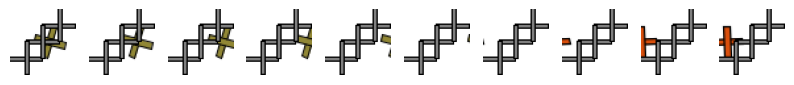

Start index: 699


<Figure size 640x480 with 0 Axes>

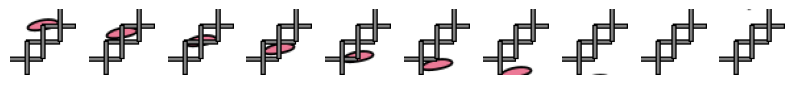

Start index: 754


<Figure size 640x480 with 0 Axes>

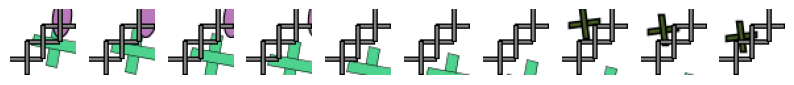

Start index: 15507


<Figure size 640x480 with 0 Axes>

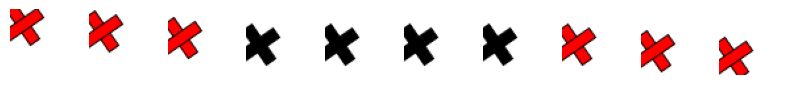

Start index: 25208


<Figure size 640x480 with 0 Axes>

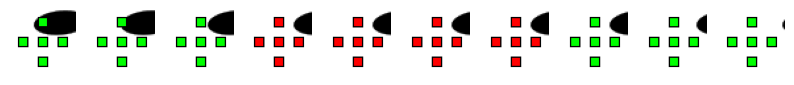

<Figure size 640x480 with 0 Axes>

In [7]:
# SPECIFY PATHS AND CREATE PLOTS

from data_utils import plot_video_sequences

data_paths = [
    "/home/evalexii/Documents/Thesis/code/parallel_prednet/data/animations/general_shape_strafing/frames/general_cross_R_test",
    "/home/evalexii/Documents/Thesis/code/parallel_prednet/data/animations/general_shape_strafing/frames/general_ellipse_D_test",
    "/home/evalexii/Documents/Thesis/code/parallel_prednet/data/animations/multi_gen_shape_strafing/frames/multi_gen_shape_test",
    "/home/evalexii/Documents/Thesis/code/parallel_prednet/data/animations/class_cond_shape_strafing/frames/class_cond_shape_2nd_stage",
    "/home/evalexii/Documents/Thesis/code/parallel_prednet/data/animations/world_cond_shape_strafing/frames/world_cond_shape_2nd_stage",
]

save_paths = [
    "/home/evalexii/Documents/Thesis/code/parallel_prednet/data/animations/general_shape_strafing/test_sample.png",
    "/home/evalexii/Documents/Thesis/code/parallel_prednet/data/animations/general_shape_strafing/test_sample.png",
    "/home/evalexii/Documents/Thesis/code/parallel_prednet/data/animations/multi_gen_shape_strafing/test_sample.png",
    "/home/evalexii/Documents/Thesis/code/parallel_prednet/data/animations/class_cond_shape_strafing/test_sample.png",
    "/home/evalexii/Documents/Thesis/code/parallel_prednet/data/animations/world_cond_shape_strafing/test_sample.png",
]

for dp, sp in zip(data_paths, save_paths):
    plot_video_sequences(data_path=dp, save_path=sp)
    # input("Press Enter to continue...")